# Telco Customer Profiling 


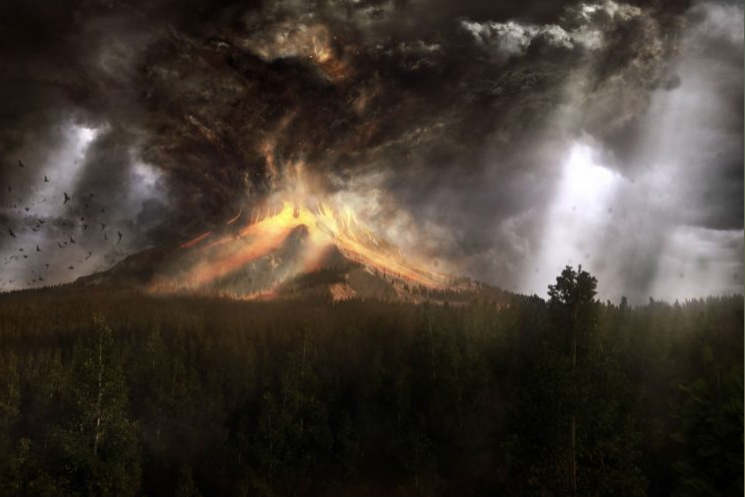 


#### _Clustering on Mixed Data Types_   
Key steps: 
* **Cleaning:**  
* **Clustering** via KPrototypes algorithm

<b>Data:</b> Data on telco customers, which comprises the options within the plans and plan usage in terms of number and duration of calls, and revenue.

# Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std, NaN
from stop_words import get_stop_words
import scipy.stats as stats
import random 
#from random import seed
#seed(1)
from collections import Counter

import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer#, SnowballStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
#nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk import pos_tag 
#from gensim import models, corpora

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import plotnine
from plotnine import *

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table_experiments as dt
from plotly import graph_objects as go 
from plotly.graph_objs import * 
from dash.dependencies import Input, Output, State
import plotly.express as px 

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline #as imbPipeline

from joblib import dump
from joblib import load
import pickle 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, PowerTransformer, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
#pip install libpysal
#pip install pygeos


# clustering
from kmodes.kprototypes import KPrototypes

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier , GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier,RandomForestRegressor

from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import classification_report, confusion_matrix, auc, accuracy_score,log_loss,roc_auc_score,roc_curve, make_scorer,r2_score,jaccard_score
from imblearn.metrics import geometric_mean_score 

""" 
import rasterio as rio
import contextily as ctx
import shapely.geometry as geom
import folium
import osmnx as ox 
from shapely.ops import nearest_points
from shapely.geometry import LineString
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from folium.plugins import FastMarkerCluster
"""
#from libpysal.weights.distance import get_points_array
from scipy.spatial import cKDTree
import mapclassify
import geopandas as gpd

#factor analysis of mixed data
from light_famd import FAMD

pd.options.display.max_columns = 35
pd.options.display.float_format ='{:.2f}'.format 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Load Data

In [2]:
pd.options.display.max_columns = 35
pd.options.display.float_format ='{:.2f}'.format

telcofile = ("TelcoChurn.xlsx")

t=pd.read_excel(telcofile)
#print(t.shape)
#t.isna().sum()
print(t.shape)
t.info()

(3333, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            3333 non-null   object 
 1   gender                3333 non-null   object 
 2   SeniorCitizen         3333 non-null   int64  
 3   MaritalStatus         3333 non-null   object 
 4   Dependents            3333 non-null   object 
 5   tenure                3333 non-null   int64  
 6   PhoneService          3333 non-null   object 
 7   MultipleLines         3333 non-null   object 
 8   InternetService       3333 non-null   object 
 9   OnlineSecurity        3333 non-null   object 
 10  OnlineBackup          3333 non-null   object 
 11  DeviceProtection      3333 non-null   object 
 12  TechSupport           3333 non-null   object 
 13  StreamingTV           3333 non-null   object 
 14  StreamingMovies       3333 non-null   object 
 15  Contract  

In [3]:
# summary of different types of variables 
discrete_type = ['int16', 'int32', 'int64']
continuous_type =['float16', 'float32', 'float64']

# numerical: discrete vs continuous
discrete = [var for var in t.columns if t[var].dtype in discrete_type and t[var].nunique()<len(t)]
continuous = [var for var in t.columns if t[var].dtype in continuous_type and var not in discrete]
# combination 
string = [discrete, continuous]

# categorical
categorical = [var for var in t.columns if t[var].dtype=='O' and var not in string and t[var].nunique()!=len(t)]

string_all = [discrete, continuous, categorical]
unique_identifier = [var for var in t.columns if t[var].dtype=='O' and var not in string_all and t[var].nunique()==len(t)]

print(f'Total number of variables = {len(t.columns)}\n')
print('{} unique id '.format(len(unique_identifier)))
print('{} discrete variables'.format(len(discrete)))
print('{} continuous variables'.format(len(continuous)))
print('{} categorical variables'.format(len(categorical)))

#print('There are {} mixed variables'.format(len(mixed)))
print(f'\nUnique identifier = {unique_identifier}')
print(f'\nCategorical variables = {categorical}')
print(f'\nDiscrete variables = {discrete}')
print(f'\nContinuous variables = {continuous}')

t.head(2)

Total number of variables = 33

1 unique id 
9 discrete variables
4 continuous variables
19 categorical variables

Unique identifier = ['customerID']

Categorical variables = ['gender', 'MaritalStatus', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan', 'TotalRevenue', 'Churn']

Discrete variables = ['SeniorCitizen', 'tenure', 'NumbervMailMessages', 'TotalDayCalls', 'TotalEveCalls', 'TotalNightCalls', 'TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall']

Continuous variables = ['TotalDayMinutes', 'TotalEveMinutes', 'TotalNightMinutes', 'TotalIntlMinutes']


,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.3,No
1,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes


# Cleaning

In [4]:
# checking for duplicates in ID 

print(f"ID ={t.customerID.dtype}\n")
t.customerID.value_counts(dropna=False).head(10)

ID =object



9534-NSXEM    1
8314-HTWVE    1
0750-EKNGL    1
0945-TSONX    1
4893-GYUJU    1
5223-UZAVK    1
7077-XJMET    1
2400-FEQME    1
8929-KSWIH    1
7268-WNTCP    1
Name: customerID, dtype: int64

In [5]:
t['SeniorCitizen'].dtype

dtype('int64')

In [6]:
t['SeniorCitizen'] = t['SeniorCitizen'].astype(int).astype(str)
t['SeniorCitizen'].dtype

dtype('O')

In [7]:
t['TotalRevenue'].dtype

dtype('O')

In [8]:
t.TotalRevenue.value_counts(dropna=False).head(10) 
# white / empty space with count of 5 items

19.75    8
19.55    7
20.05    7
19.65    7
19.9     6
20.2     6
45.3     5
         5
20.15    5
19.45    5
Name: TotalRevenue, dtype: int64

In [9]:
# converting TotalRevenue column with mixed data types to float 

t.TotalRevenue = pd.to_numeric(t.TotalRevenue, errors='coerce') # 
t.TotalRevenue.value_counts(dropna=False).head(10) 
#nan values below from previous empty/white space

19.75    8
19.55    7
19.65    7
20.05    7
20.20    6
19.90    6
NaN      5
45.30    5
20.45    5
19.45    5
Name: TotalRevenue, dtype: int64

In [10]:
t_notnull = t[t['TotalRevenue'].notnull()]
t_notnull.info()  #isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3328 entries, 0 to 3332
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customerID            3328 non-null   object 
 1   gender                3328 non-null   object 
 2   SeniorCitizen         3328 non-null   object 
 3   MaritalStatus         3328 non-null   object 
 4   Dependents            3328 non-null   object 
 5   tenure                3328 non-null   int64  
 6   PhoneService          3328 non-null   object 
 7   MultipleLines         3328 non-null   object 
 8   InternetService       3328 non-null   object 
 9   OnlineSecurity        3328 non-null   object 
 10  OnlineBackup          3328 non-null   object 
 11  DeviceProtection      3328 non-null   object 
 12  TechSupport           3328 non-null   object 
 13  StreamingTV           3328 non-null   object 
 14  StreamingMovies       3328 non-null   object 
 15  Contract             

In [11]:
# Inspect data of type object 
t_notnull.select_dtypes('object').nunique()

customerID           3328
gender                  2
SeniorCitizen           2
MaritalStatus           2
Dependents              2
PhoneService            1
MultipleLines           2
InternetService         3
OnlineSecurity          3
OnlineBackup            3
DeviceProtection        3
TechSupport             3
StreamingTV             3
StreamingMovies         3
Contract                3
PaperlessBilling        2
PaymentMethod           4
InternationalPlan       2
VoiceMailPlan           2
Churn                   2
dtype: int64

In [12]:
t2 = t_notnull.copy()

#limiting dataframe to customers only 
#t2 = t2.loc[t2.Churn == 'No']

# Data pre-processing
t2.drop(columns=['customerID','PhoneService'], axis = 1, inplace = True)
# Show the data after pre-processing
print('Dataframe shape: {} rows and {} columns'.format(len(t2), len(t2.columns)))

#t2.drop(discrete, axis=1, inplace=True)

t2.head()

Dataframe shape: 3328 rows and 31 columns


,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn
0,Female,0,Yes,Yes,9,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30,No
1,Male,0,No,No,4,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes
2,Female,0,No,Yes,9,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,178.70,134,178.60,102,126.80,82,8.00,4,2,324,571.45,No
3,Female,1,Yes,No,71,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),No,No,0,190.20,68,262.20,64,130.00,92,8.80,4,0,228,7904.25,No
4,Female,1,No,No,7,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,0,67.70,68,195.70,86,236.50,137,12.00,2,1,294,340.35,No


In [13]:
#t2.drop(discrete, axis=1, inplace=True)
#print(t2.shape)

In [14]:
# The distribution per gender 
t_gender = pd.DataFrame(t['gender'].value_counts()).reset_index()
t_gender['percentage'] = t_gender['gender'] / t['gender'].value_counts().sum()
t_gender.rename(columns = {'index':'gender', 'gender':'total'}, inplace = True)
t_gender = t_gender.sort_values('total', ascending = True).reset_index(drop = True)

# The dataframe
t_gender = t.groupby('gender').agg({
    'gender': 'count',
    'tenure':'sum',
    'NumbervMailMessages':'sum',
    'CustomerServiceCalls': 'sum',
    'TotalDayMinutes':'sum',
    'TotalIntlCalls':'sum',
    'TotalCall': 'sum',
    'TotalRevenue': 'mean'
    }
).rename(columns = {'gender': 'Total'}).reset_index().sort_values('Total', ascending = True)

t_gender

,gender,Total,tenure,NumbervMailMessages,CustomerServiceCalls,TotalDayMinutes,TotalIntlCalls,TotalCall,TotalRevenue
0,Female,1621,45271,13562,2557,291760.70,7281,497495,1642.93
1,Male,1712,48058,13432,2652,307429.70,7649,524736,1702.03


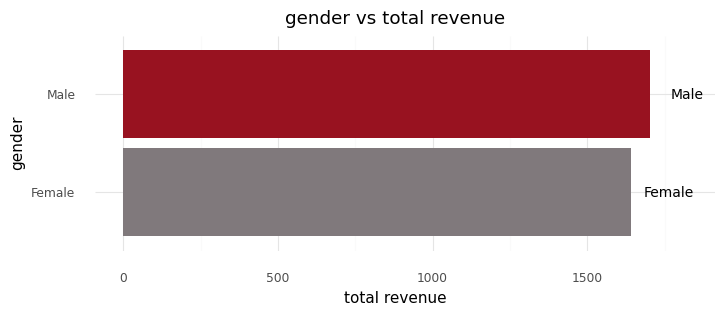

<ggplot: (133293282548)>

In [15]:
# Visualization of total revenue per gender
plotnine.options.figure_size = (8, 2.8)
(
    ggplot(data = t_gender)+
    geom_bar(aes(x = 'gender',
                 y = 'TotalRevenue'),
             fill = np.where(t_gender['gender'] == 'Male', '#981220', '#80797c'),
             stat = 'identity')+
    geom_text(aes(x = 'gender',
                   y = 'TotalRevenue',
                   label = 'gender'),
               size = 10,
               nudge_y = 120)+
    labs(title = 'gender vs total revenue')+
    xlab('gender')+
    ylab('total revenue')+
    scale_x_discrete(limits = t_gender['gender'].tolist())+
    theme_minimal()+
    coord_flip()
)


In [16]:
# The distribution per marital status 
t_MaritalStatus = pd.DataFrame(t['MaritalStatus'].value_counts()).reset_index()
t_MaritalStatus['percentage'] = t_MaritalStatus['MaritalStatus'] / t['MaritalStatus'].value_counts().sum()
t_MaritalStatus.rename(columns = {'index':'MaritalStatus', 'MaritalStatus':'total'}, inplace = True)
t_MaritalStatus = t_MaritalStatus.sort_values('total', ascending = True).reset_index(drop = True)

# The dataframe
t_MaritalStatus = t.groupby('MaritalStatus').agg({
    'MaritalStatus': 'count',
    'tenure':'sum',
    'NumbervMailMessages':'sum',
    'CustomerServiceCalls': 'sum',
    'TotalDayMinutes':'sum',
    'TotalIntlCalls':'sum',
    'TotalCall': 'sum',
    'TotalRevenue': 'mean'
    }
).rename(columns = {'MaritalStatus': 'Total'}).reset_index().sort_values('Total', ascending = True)

t_MaritalStatus

,MaritalStatus,Total,tenure,NumbervMailMessages,CustomerServiceCalls,TotalDayMinutes,TotalIntlCalls,TotalCall,TotalRevenue
1,Yes,1502,56264,12552,2243,267176.20,6789,460325,2294.03
0,No,1831,37065,14442,2966,332014.20,8141,561906,1165.15


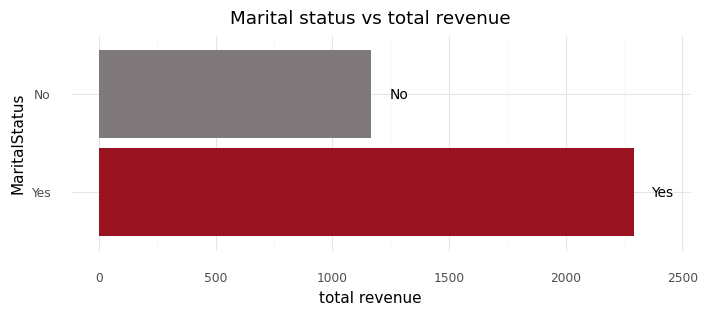

<ggplot: (133293428402)>

In [17]:
# Visualization of total revenue per marital status
plotnine.options.figure_size = (8, 2.8)
(
    ggplot(data = t_MaritalStatus)+
    geom_bar(aes(x = 'MaritalStatus',
                 y = 'TotalRevenue'),
             fill = np.where(t_MaritalStatus['MaritalStatus'] == 'Yes', '#981220', '#80797c'),
             stat = 'identity')+
    geom_text(aes(x = 'MaritalStatus',
                   y = 'TotalRevenue',
                   label = 'MaritalStatus'),
               size = 10,
               nudge_y = 120)+
    labs(title = 'Marital status vs total revenue')+
    xlab('MaritalStatus')+
    ylab('total revenue')+
    scale_x_discrete(limits = t_MaritalStatus['MaritalStatus'].tolist())+
    theme_minimal()+
    coord_flip()
)


In [18]:
# summary of different types of variables 
discrete_type = ['int16', 'int32', 'int64']
continuous_type =['float16', 'float32', 'float64']

# numerical: discrete vs continuous
discrete = [var for var in t2.columns if t2[var].dtype in discrete_type and t2[var].nunique()<len(t2)]
continuous = [var for var in t2.columns if t2[var].dtype in continuous_type and var not in discrete]
# combination 
string = [discrete, continuous]

# categorical
categorical = [var for var in t2.columns if t2[var].dtype=='O' and var not in string and t2[var].nunique()!=len(t2)]

string_all = [discrete, continuous, categorical]
unique_identifier = [var for var in t2.columns if t2[var].dtype=='O' and var not in string_all and t2[var].nunique()==len(t2)]

print(f'Total number of variables = {len(t2.columns)}\n')
print('{} unique id '.format(len(unique_identifier)))
print('{} discrete variables'.format(len(discrete)))
print('{} continuous variables'.format(len(continuous)))
print('{} categorical variables'.format(len(categorical)))

#print('There are {} mixed variables'.format(len(mixed)))
print(f'\nUnique identifier = {unique_identifier}')
print(f'\nCategorical variables = {categorical}')
print(f'\nDiscrete variables = {discrete}')
print(f'\nContinuous variables = {continuous}')

t.head(2)

Total number of variables = 31

0 unique id 
8 discrete variables
5 continuous variables
18 categorical variables

Unique identifier = []

Categorical variables = ['gender', 'SeniorCitizen', 'MaritalStatus', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'InternationalPlan', 'VoiceMailPlan', 'Churn']

Discrete variables = ['tenure', 'NumbervMailMessages', 'TotalDayCalls', 'TotalEveCalls', 'TotalNightCalls', 'TotalIntlCalls', 'CustomerServiceCalls', 'TotalCall']

Continuous variables = ['TotalDayMinutes', 'TotalEveMinutes', 'TotalNightMinutes', 'TotalIntlMinutes', 'TotalRevenue']


,customerID,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30,No
1,0004-TLHLJ,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes


In [19]:
# position of categorical columns
categorical_column_positions = [t2.columns.get_loc(col) for col in list(t2.select_dtypes('object').columns)]
categorical_column_positions

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 30]

In [20]:
# Convert cluster dataframe to matrix
t2matrix = t2.to_numpy()
t2matrix

array([['Female', '0', 'Yes', ..., 354, 593.3, 'No'],
       ['Male', '0', 'No', ..., 326, 280.85, 'Yes'],
       ['Female', '0', 'No', ..., 324, 571.45, 'No'],
       ...,
       ['Female', '0', 'No', ..., 349, 742.9, 'No'],
       ['Male', '0', 'No', ..., 299, 92.75, 'No'],
       ['Male', '0', 'Yes', ..., 299, 4627.65, 'No']], dtype=object)

## Clustering

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


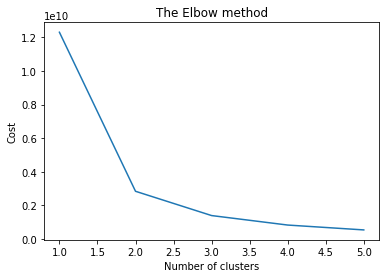

In [21]:
# Elbow method
wcss = []


for cluster in range(1,6):
    kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kprototype.fit_predict(t2matrix, categorical = categorical_column_positions)
    wcss.append(kprototype.cost_)
    print('Cluster initiation: {}'.format(cluster))
    
#plot the graph of wcss values
plt.plot(range(1,6), wcss)
plt.title("The Elbow method")
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.show()

In [22]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
predictions = kprototype.fit_predict(t2matrix, categorical = categorical_column_positions)
predictions

array([1, 1, 1, ..., 1, 1, 2], dtype=uint16)

In [23]:
# Cluster centorid
print('\nCluster centroid: ', kprototype.cluster_centroids_)

# Check the iteration of the clusters created
print('\nCluster iteration: ', kprototype.n_iter_)

# Check the cost of the clusters created
print('\nCost of clusters: ', kprototype.cost_)


Cluster centroid:  [['39.75766871165644' '8.053680981595091' '179.0315950920243'
  '99.67791411042944' '198.87791411042954' '99.40184049079754'
  '203.7766871165645' '100.29601226993866' '10.156901840490802'
  '4.457055214723926' '1.5582822085889572' '305.3911042944785'
  '2884.6609662576716' 'Male' '0' 'Yes' 'No' 'No' 'DSL' 'No' 'No' 'No'
  'No' 'No' 'No' 'Month-to-month' 'Yes' 'Electronic check' 'No' 'No' 'No']
 ['18.286472148541115' '7.916003536693192' '180.2732537577366'
  '100.83244916003537' '202.13001768346606' '100.10477453580901'
  '200.74155614500475' '100.17506631299734' '10.261892130857659'
  '4.464633068081344' '1.5950486295313882' '307.1719717064545'
  '562.5175287356318' 'Male' '0' 'No' 'No' 'No' 'No'
  'No internet service' 'No internet service' 'No internet service'
  'No internet service' 'No internet service' 'No internet service'
  'Month-to-month' 'No' 'Mailed check' 'No' 'No' 'No']
 ['62.905797101449274' '9.128019323671497' '178.1234299516909'
  '99.4565217391304

In [24]:
# Add the cluster to the dataframe
t2['cluster_label'] = kprototype.labels_
t2['segment'] = t2['cluster_label'].map({0:'first', 1:'second', 2:'third'})
# Order the cluster
t2['segment'] = t2['segment'].astype('category')
t2['segment'] = t2['segment'].cat.reorder_categories(['first','second', 'third'])

print(t2.shape)
t2.head(3)

(3328, 33)


,gender,SeniorCitizen,MaritalStatus,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Churn,cluster_label,segment
0,Female,0,Yes,Yes,9,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,No,No,0,168.80,137,241.40,107,204.80,106,15.50,4,0,354,593.30,No,1,second
1,Male,0,No,No,4,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,Yes,No,0,122.20,112,131.70,94,169.50,106,10.30,9,5,326,280.85,Yes,1,second
2,Female,0,No,Yes,9,No,DSL,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),No,Yes,36,178.70,134,178.60,102,126.80,82,8.00,4,2,324,571.45,No,1,second


## Interpretation

In [25]:
t2.groupby('segment')['SeniorCitizen'].value_counts()

segment  SeniorCitizen
first    0                 549
         1                 103
second   0                2063
         1                 199
third    0                 349
         1                  65
Name: SeniorCitizen, dtype: int64

In [26]:
t2.groupby('segment')['MaritalStatus'].value_counts()

segment  MaritalStatus
first    Yes               353
         No                299
second   No               1419
         Yes               843
third    Yes               302
         No                112
Name: MaritalStatus, dtype: int64

In [27]:
t2.groupby('segment')['PaymentMethod'].value_counts()

segment  PaymentMethod            
first    Electronic check             198
         Bank transfer (automatic)    181
         Credit card (automatic)      165
         Mailed check                 108
second   Mailed check                 904
         Electronic check             598
         Bank transfer (automatic)    388
         Credit card (automatic)      372
third    Credit card (automatic)      167
         Bank transfer (automatic)    125
         Electronic check              91
         Mailed check                  31
Name: PaymentMethod, dtype: int64

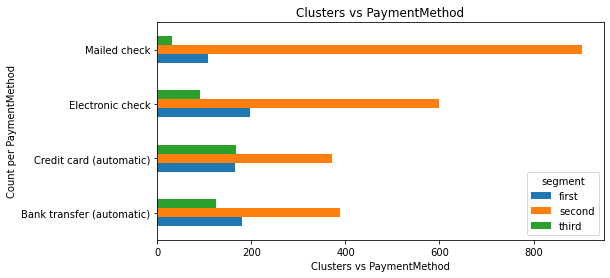

In [28]:
ax = t2.groupby(['segment','PaymentMethod'])['segment'].count().unstack(0).\
                plot.barh(title="Clusters vs PaymentMethod", figsize=(8,4))
_ = ax.set_xlabel('Clusters vs PaymentMethod')
_ = ax.set_ylabel('Count per PaymentMethod')

In [29]:
merged_df = t2.copy()
merged_df.rename(columns = {'cluster_label':'Total'}, inplace = True)
merged_df.groupby('segment').agg(
    {
        'Total':'count',
        'gender': lambda x: x.value_counts().index[0],
        'SeniorCitizen': lambda x: x.value_counts().index[0],
        'MaritalStatus': lambda x: x.value_counts().index[0],
        'Dependents': lambda x: x.value_counts().index[0],
       # 'PhoneService': lambda x: x.value_counts().index[0],
        'MultipleLines': lambda x: x.value_counts().index[0],
        'InternetService': lambda x: x.value_counts().index[0],
        'OnlineSecurity': lambda x: x.value_counts().index[0],
        'OnlineBackup': lambda x: x.value_counts().index[0],
        'DeviceProtection': lambda x: x.value_counts().index[0],
        'TechSupport': lambda x: x.value_counts().index[0],
        'StreamingTV': lambda x: x.value_counts().index[0],
        'StreamingMovies': lambda x: x.value_counts().index[0],
        'Contract': lambda x: x.value_counts().index[0],
        'PaperlessBilling': lambda x: x.value_counts().index[0],
        'PaymentMethod': lambda x: x.value_counts().index[0],
        'InternationalPlan': lambda x: x.value_counts().index[0],
        'VoiceMailPlan': lambda x: x.value_counts().index[0],
        'TotalDayMinutes': 'mean',
        'TotalDayCalls': 'mean',
        'TotalEveMinutes': 'mean',
        'TotalEveCalls': 'mean',
        'TotalNightMinutes': 'mean',
         'TotalNightCalls': 'mean',
        'TotalIntlMinutes': 'mean',
        'TotalIntlCalls': 'mean',
        'TotalEveCalls': 'mean',
        'TotalNightMinutes': 'mean',
        'TotalRevenue':'mean'
    }
).reset_index()

,segment,Total,gender,SeniorCitizen,MaritalStatus,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,InternationalPlan,VoiceMailPlan,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,TotalRevenue
0,first,652,Male,0,Yes,No,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,No,179.03,99.68,198.88,99.40,203.78,100.30,10.16,4.46,2884.66
1,second,2262,Male,0,No,No,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,No,No,180.27,100.83,202.13,100.10,200.74,100.18,10.26,4.46,562.52
2,third,414,Male,0,Yes,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),No,No,178.12,99.46,198.08,101.37,197.14,99.52,10.22,4.60,5834.44


In [30]:
customer_plan_options = list(merged_df.columns[:])
customer_output = list(merged_df.columns[:])

In [31]:
customer_output_df = merged_df.copy()
merged_df.segment = merged_df.segment.astype('object')

customer_output_df = merged_df.groupby('segment')[customer_output].mean()
customer_output_df

,tenure,NumbervMailMessages,TotalDayMinutes,TotalDayCalls,TotalEveMinutes,TotalEveCalls,TotalNightMinutes,TotalNightCalls,TotalIntlMinutes,TotalIntlCalls,CustomerServiceCalls,TotalCall,TotalRevenue,Total
segment,,,,,,,,,,,,,,
first,39.76,8.05,179.03,99.68,198.88,99.40,203.78,100.30,10.16,4.46,1.56,305.39,2884.66,0
second,18.29,7.92,180.27,100.83,202.13,100.10,200.74,100.18,10.26,4.46,1.60,307.17,562.52,1
third,62.91,9.13,178.12,99.46,198.08,101.37,197.14,99.52,10.22,4.60,1.39,306.33,5834.44,2


In [32]:
a = customer_output_df.copy() 
a2 = a.reset_index(drop=False).T.reset_index()
a2.columns = ['customer_output','first_segment','second_segment','third_segment']
a2.iloc[1:-1,:]

,customer_output,first_segment,second_segment,third_segment
1,tenure,39.76,18.29,62.91
2,NumbervMailMessages,8.05,7.92,9.13
3,TotalDayMinutes,179.03,180.27,178.12
4,TotalDayCalls,99.68,100.83,99.46
5,TotalEveMinutes,198.88,202.13,198.08
6,TotalEveCalls,99.4,100.1,101.37
7,TotalNightMinutes,203.78,200.74,197.14
8,TotalNightCalls,100.3,100.18,99.52
9,TotalIntlMinutes,10.16,10.26,10.22
10,TotalIntlCalls,4.46,4.46,4.6
